<h1>LDA model<h1>

In [68]:
# folder path
folder_path = "Theses_clean_data/text.csv"

# Installing packages

In [70]:
pip install --upgrade pyLDAvis gensim

Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.


In [72]:
pip install --upgrade joblib

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [74]:
! pip install SpaCy
! python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [75]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [76]:
import pandas as pd
import random
import numpy as np
import re
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, Phrases
from gensim.models.phrases import Phraser
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /Users/mike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mike/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Adding custom stopwords

In [78]:
stopwords_path = 'USPTO_stopwords_en.txt'

In [79]:
uspto_stopwords = open('USPTO_stopwords_en.txt',"r")
print(uspto_stopwords.read())

a
accordance
according
all
also
an
and
another
are
as
at
be
because
been
being
by
claim
comprises
corresponding
could
described
desired
do
does
each
embodiment
fig
figs
for
from
further
generally
had
has
have
having
herein
however
if
in
into
invention
is
it
its
means
not
now
of
on
onto
or
other
particularly
preferably
preferred
present
provide
provided
provides
relatively
respectively
said
should
since
some
such
suitable
than
that
the
their
then
there
thereby
therefore
thereof
thereto
these
they
this
those
thus
to
use
various
was
were
what
when
where
whereby
wherein
which
while
who
will
with
would



In [80]:
stop_words = set(stopwords.words('english'))

In [81]:
print(stop_words)

{'because', 'off', "they're", "wasn't", 't', 'them', 'needn', 'yourselves', 'after', 'from', 'more', "shouldn't", 'wouldn', 'weren', 'were', 'have', 'theirs', 'same', 'during', 'couldn', 'shan', 'wasn', 'didn', 'few', 'haven', 'some', 'between', "she'd", "it'll", 'or', 'the', 'until', "i'll", 'in', "they'll", 'where', 'further', 'yours', "that'll", 'won', 'doing', "haven't", 'he', "he's", 'that', 'you', "you've", 'most', 'both', 'hadn', 'under', "didn't", 'y', "wouldn't", 'just', 'yourself', 'is', "they'd", "doesn't", 'mustn', 'm', 'which', 'they', "won't", "aren't", 'her', "i'm", 'before', 'not', "she'll", 'had', 'with', 'only', 'down', "he'll", 's', 'so', 'own', 'then', 'but', "you'll", 'now', 'against', 'does', 'by', "don't", 'through', "weren't", 'again', 'all', 'if', 're', 'how', 'here', "we'll", 'this', 'once', 'themselves', "hadn't", "couldn't", 'who', 'when', 'no', 'has', 'shouldn', "mightn't", "she's", 'our', 'over', 'why', 'will', 'an', 'of', 'very', 'ain', 'below', 'can', 'i

In [82]:
# stopwords to add: one, first, second, comprising, least, method, end

In [83]:
number_words = [
            "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
            "first", "second", "third", "fourth", "fifth", "sixth", "seventh", "eighth", "ninth", "tenth",
            "eleventh", "twelfth", "thirteenth", "fourteenth", "fifteenth", "sixteenth", "seventeenth", "eighteenth", "nineteenth", "twenty",]

In [84]:
extra_stopwords = ["comprising", "least", "method", "end", "set"]

In [85]:
df = pd.read_csv(folder_path)

In [86]:
#extending nltk corpus stopwords
uspto_stopwords = set()
with open("USPTO_stopwords_en.txt", "r", encoding="utf-8") as file:
    uspto_stopwords = {line.strip() for line in file if line.strip()}

extended_stopwords = stop_words.union(extra_stopwords, number_words, uspto_stopwords)
print(list(extended_stopwords)[:])

['because', 'eight', "wasn't", 'ninth', 'since', 'twelfth', 'invention', 'them', 'fourteenth', 'needn', 'yourselves', 'five', 'more', 'weren', 'were', 'same', 'couldn', 'wasn', 'twenty', 'didn', 'few', 'haven', 'some', 'between', 'three', "it'll", 'in', "they'll", 'tenth', 'end', "that'll", 'won', 'doing', "he's", 'that', "you've", 'most', 'said', 'set', 'fifth', 'yourself', "they'd", "doesn't", 'also', 'they', 'second', 'her', "i'm", 'provided', 'thereby', 'down', "he'll", 's', 'embodiment', 'own', 'but', "you'll", 'thirteenth', 'one', 'against', 'does', 'thus', 'again', 'all', 're', 'desired', 'this', 'once', 'themselves', "couldn't", 'has', "mightn't", 'will', 'an', 'however', 'very', 'ain', 'below', 'itself', 'comprising', 'such', 'my', 'these', 'accordance', 'me', 'ten', 'their', 'his', 'been', 'mightn', 'wherein', 'six', 'd', "i'd", 'above', 'thereof', 'according', 'a', 'at', 'while', 'other', 'preferred', 'onto', 'it', 'll', 'use', 'for', 'could', 'relatively', 'ourselves', 'bei

In [87]:
print(f"Extended Stopwords: {len(extended_stopwords)} words")
print(f"NLTK Stopwords: {len(stop_words)} words")

Extended Stopwords: 274 words
NLTK Stopwords: 198 words


# Def preprocessing functions

In [89]:
text_column = "Claims"
sample_df = df[text_column].sample(n=10000, random_state=42).dropna().tolist()

In [90]:
# remove white spaces 
sample_df = [re.sub(r'\s+', ' ', sent) for sent in sample_df]

In [91]:
#def tokenization using gensim
def tokenize_text(text):
    return gensim.utils.simple_preprocess(text, deacc=True)

In [92]:
# remove stopwords
def preprocess_texts(texts, extended_stopwords):
    return [[word for word in tokenize_text(text) if word not in extended_stopwords] for text in texts]

In [93]:
#Creating n-grams
def create_ngrams(texts, min_count=5, threshold=100):
    bigram_phrases = gensim.models.Phrases(texts, min_count=min_count, threshold=threshold)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[texts], threshold=threshold)
    
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    
    bigrams = [bigram[doc] for doc in texts]
    trigrams = [trigram[bigram[doc]] for doc in bigrams]
    
    return trigrams

In [94]:
def lemmatize_texts(texts, allowed_postags, extended_stopwords):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    allowed_postags_set = set(allowed_postags)
    
    lemmatized_texts = []
    for doc in nlp.pipe([" ".join(text) for text in texts], batch_size=500):
        lemmatized_texts.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags_set and token.lemma_ not in extended_stopwords]
        )
    
    return lemmatized_texts

In [95]:
def create_dictionary_and_corpus(texts):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

In [96]:
# Finding optimal topic number by coherence scores
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=18, step=2):
    coherence_scores = []
    model_list = []
    topic_range = range(start, limit, step)
    
    for num_topics in topic_range:
        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)
        model_list.append(lda_model)
        
        #coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics = {num_topics}, Coherence Score = {coherence_score:.4f}")

    return topic_range, coherence_scores, model_list

# plot coherence scores
def plot_coherence_scores(topic_range, coherence_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', color='b', label="Coherence Score")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score vs. Number of Topics")
    plt.legend()
    plt.grid()
    plt.show()

# N-grams -> Lemmetization

Num Topics = 2, Coherence Score = 0.4624
Num Topics = 4, Coherence Score = 0.4335
Num Topics = 6, Coherence Score = 0.4569
Num Topics = 8, Coherence Score = 0.4876
Num Topics = 10, Coherence Score = 0.4643
Num Topics = 12, Coherence Score = 0.4579
Num Topics = 14, Coherence Score = 0.4534
Num Topics = 16, Coherence Score = 0.4493


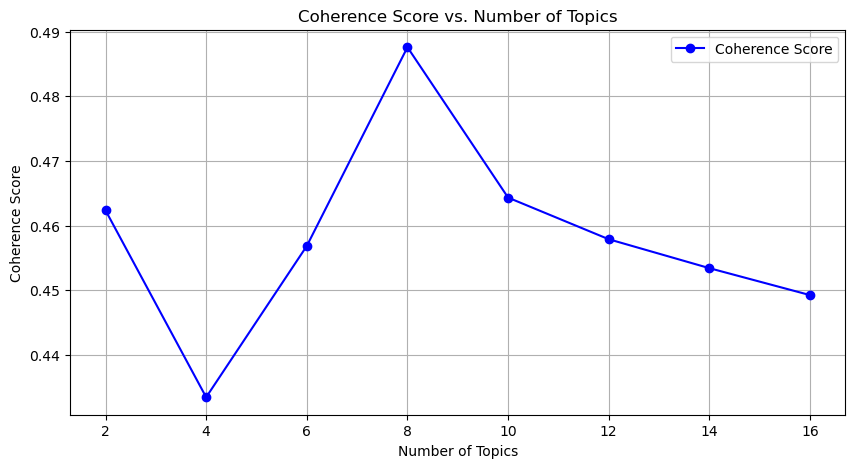

In [98]:
def main1():
    # Preprocess texts
    tokenized_texts = preprocess_texts(sample_df,extended_stopwords )

    # Create bigrams and trigrams
    data_bigrams_trigrams = create_ngrams(tokenized_texts, min_count=5, threshold=100)

    # Lemmatize texts 
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"] 
    lemmatized_texts = lemmatize_texts(data_bigrams_trigrams, allowed_postags, extended_stopwords)
    
    # Create Dictionary and Corpus
    dictionary_1, corpus_1 = create_dictionary_and_corpus(lemmatized_texts)
    
    # coherence
    start, limit, step = 2, 18, 2 
    topic_range, coherence_scores, model_list = compute_coherence_values(dictionary_1, corpus_1, lemmatized_texts, start, limit, step)
    plot_coherence_scores(topic_range, coherence_scores)

    return corpus_1, dictionary_1, lemmatized_texts  

corpus_1, dictionary_1, lemmatized_texts = main1()

if __name__ == "__main1__":
    pass

In [137]:
lda_model_1 = gensim.models.ldamodel.LdaModel(corpus=corpus_1,
                                           id2word=dictionary_1,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [138]:
lda_visualization_1 = gensimvis.prepare(lda_model_1, corpus_1, dictionary_1)

pyLDAvis.display(lda_visualization_1)

# Lemmetization -> N-grams

Num Topics = 2, Coherence Score = 0.4412
Num Topics = 4, Coherence Score = 0.4397
Num Topics = 6, Coherence Score = 0.4605
Num Topics = 8, Coherence Score = 0.4656
Num Topics = 10, Coherence Score = 0.4697
Num Topics = 12, Coherence Score = 0.4545
Num Topics = 14, Coherence Score = 0.4739
Num Topics = 16, Coherence Score = 0.4858


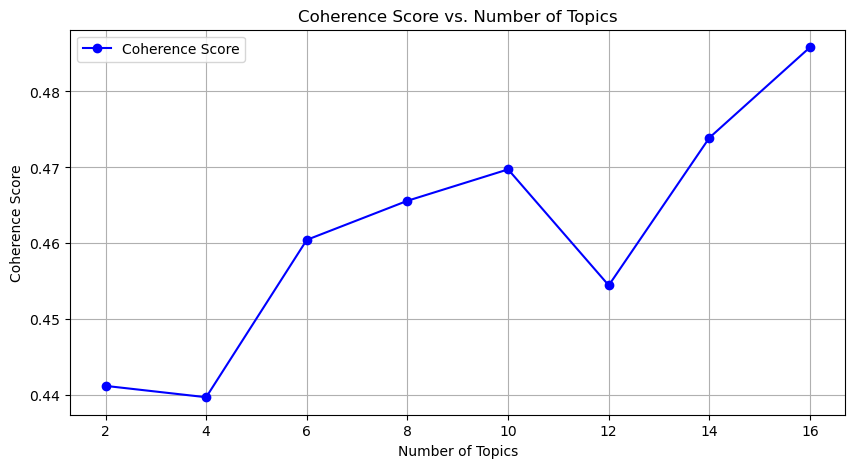

In [102]:
def main2():
    # Preprocess texts
    tokenized_texts = preprocess_texts(sample_df,extended_stopwords)

    # Lemmatize texts 
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"] 
    lemmatized_texts = lemmatize_texts(tokenized_texts, allowed_postags,extended_stopwords)

    # Create bigrams and trigrams
    data_bigrams_trigrams = create_ngrams(lemmatized_texts, min_count=5, threshold=100)
    
    # Create Dictionary and Corpus
    dictionary_2, corpus_2 = create_dictionary_and_corpus(data_bigrams_trigrams)
    
    # coherence
    start, limit, step = 2, 18, 2 
    topic_range, coherence_scores, model_list = compute_coherence_values(dictionary_2, corpus_2, data_bigrams_trigrams, start, limit, step)
    plot_coherence_scores(topic_range, coherence_scores)

    return corpus_2, dictionary_2, data_bigrams_trigrams  

corpus_2, dictionary_2, data_bigrams_trigrams = main2()

if __name__ == "__main2__":
    pass

In [145]:
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus_2,
                                           id2word=dictionary_2,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [146]:
lda_visualization_2 = gensimvis.prepare(lda_model_2, corpus_2, dictionary_2)

pyLDAvis.display(lda_visualization_2)